In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG19
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.losses import categorical_crossentropy
import tensorflow as tf
from sklearn.metrics import balanced_accuracy_score, precision_recall_fscore_support, confusion_matrix, classification_report, cohen_kappa_score
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import OneHotEncoder
from collections import Counter
from tensorflow.keras.layers import Dense, Flatten, Dropout


In [2]:
epochs = 15
learning_rate = 3.9e-5
# Parameters
IMG_HEIGHT = 224
IMG_WIDTH = 224
BATCH_SIZE = 32
AUTOTUNE = tf.data.AUTOTUNE
folder_path = './../../datasets/dataset1'
num_classes = 5
validation_split = 0.2
test_split = 0.2  # Proportion of the data to use for testing

# Load image file paths and their corresponding labels
image_paths = []
labels = []

class_names = sorted(os.listdir(folder_path))
class_indices = {name: i for i, name in enumerate(class_names)}

for class_name in class_names:
    class_path = os.path.join(folder_path, class_name)
    for file_name in os.listdir(class_path):
        file_path = os.path.join(class_path, file_name)
        image_paths.append(file_path)
        labels.append(class_indices[class_name])

image_paths = np.array(image_paths)
labels = np.array(labels)

# Split the data into training, validation, and test sets
train_paths, test_paths, train_labels, test_labels = train_test_split(image_paths, labels, test_size=test_split, stratify=labels, random_state=42)
train_paths, val_paths, train_labels, val_labels = train_test_split(train_paths, train_labels, test_size=validation_split, stratify=train_labels, random_state=42)

# Function to load and preprocess the images
def preprocess_image(image_path, label):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [IMG_HEIGHT, IMG_WIDTH])
    image = image / 255.0  # Normalize to [0,1]
    label = tf.one_hot(label, num_classes)
    return image, label

# Create TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_paths, train_labels))
train_dataset = train_dataset.map(preprocess_image, num_parallel_calls=AUTOTUNE)
train_dataset = train_dataset.shuffle(buffer_size=len(train_paths)).batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)

val_dataset = tf.data.Dataset.from_tensor_slices((val_paths, val_labels))
val_dataset = val_dataset.map(preprocess_image, num_parallel_calls=AUTOTUNE)
val_dataset = val_dataset.batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)

test_dataset = tf.data.Dataset.from_tensor_slices((test_paths, test_labels))
test_dataset = test_dataset.map(preprocess_image, num_parallel_calls=AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)

# Now train_dataset, val_dataset, and test_dataset are ready to use

In [3]:
# class_weights = compute_class_weight('balanced', classes=np.unique(test_generator.classes), y=test_generator.classes)
# class_weights_dict = dict(enumerate(class_weights))

# print("Class weights: ", class_weights_dict)


In [4]:
# # Define a custom weighted categorical cross-entropy loss function
# def weighted_categorical_crossentropy(weights):
#     def loss(y_true, y_pred):
#         y_true = tf.cast(y_true, tf.float32)
#         y_pred = tf.cast(y_pred, tf.float32)
#         weights_tensor = tf.reduce_sum(weights * y_true, axis=-1)
#         unweighted_losses = categorical_crossentropy(y_true, y_pred)
#         weighted_losses = unweighted_losses * weights_tensor
#         return tf.reduce_mean(weighted_losses)
#     return loss

# loss_fn = weighted_categorical_crossentropy(class_weights)

In [5]:
def balanced_accuracy(y_true, y_pred):
    y_true = tf.argmax(y_true, axis=1)
    y_pred = tf.argmax(y_pred, axis=1)
    return tf.py_function(
        func=lambda y_true, y_pred: balanced_accuracy_score(
            y_true.numpy(), y_pred.numpy()),
        inp=[y_true, y_pred],
        Tout=tf.float64)


def fscore(y_true, y_pred):
    y_true = tf.cast(tf.argmax(y_true, axis=1), tf.int32)
    y_pred = tf.cast(tf.argmax(y_pred, axis=1), tf.int32)

    def compute_fscore(y_true, y_pred):
        _, _, fscore, _ = precision_recall_fscore_support(
            y_true, y_pred, average='macro', zero_division=0)
        return fscore

    return tf.py_function(func=compute_fscore, inp=[y_true, y_pred], Tout=tf.float64)

# Custom Kappa Metric
def kappa_score(y_true, y_pred):
    y_true = tf.argmax(y_true, axis=1)
    y_pred = tf.argmax(y_pred, axis=1)
    kappa_score = tf.py_function(func=cohen_kappa_score, inp=[y_true, y_pred], Tout=tf.float32)
    return kappa_score

In [6]:

metrics = [
    'accuracy',
    tf.keras.metrics.AUC(),
    balanced_accuracy,
    fscore,
    kappa_score,
    tf.keras.metrics.Precision(),
    tf.keras.metrics.Recall()
]

In [7]:
import warnings
warnings.filterwarnings('ignore', message="A single label was found in y_true and y_pred.")
warnings.filterwarnings('ignore', message="y_pred contains classes not in y_true") 
warnings.filterwarnings('ignore', message="A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.") 


def accuracyGraph(history):
    train_accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']

    # Assuming 'epochs' is defined and contains the number of epochs
    epochs_no = range(epochs)

    # Plot accuracy
    plt.figure(figsize=(14, 7))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_no, train_accuracy, 'r', label='Train Accuracy')
    plt.plot(epochs_no, val_accuracy, 'b', label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs_no, train_loss, 'r', label='Train Loss')
    plt.plot(epochs_no, val_loss, 'b', label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()
    
def show_confusion_matrix(model):
    # Get true labels and predictions
    y_true = []
    y_pred = []

    for images, labels in test_dataset:
        y_true.extend(np.argmax(labels.numpy(), axis=1))
        predictions = model.predict(images)
        y_pred.extend(np.argmax(predictions, axis=1))
    
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    # Generate classification report
    print(classification_report(y_true, y_pred, target_names=[str(i) for i in range(num_classes)]))
    
    # Compute confusion matrix
    conf_matrix = confusion_matrix(y_true, y_pred)
    print(conf_matrix)

    # Plot confusion matrix
    def plot_confusion_matrix(cm, class_names):
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.title('Confusion Matrix')
        plt.show()

    plot_confusion_matrix(conf_matrix, [str(i) for i in range(num_classes)])
    

In [8]:
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(IMG_WIDTH, IMG_HEIGHT, 3))
# Add custom top layers
for layer in base_model.layers:
    layer.trainable = False
    
x = Flatten()(base_model.output)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(5, activation='softmax')(x)  # 5 classes for diabetic retinopathy
model = Model(inputs=base_model.input, outputs=output)

80134624/80134624 [==============================] - 2s 0us/step


In [9]:
# Compile the model with the custom loss function
model.compile(optimizer=Adam(learning_rate=learning_rate), loss="categorical_crossentropy", metrics=metrics)
print(model.summary())


# Train the model
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=epochs,
    batch_size=BATCH_SIZE
)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

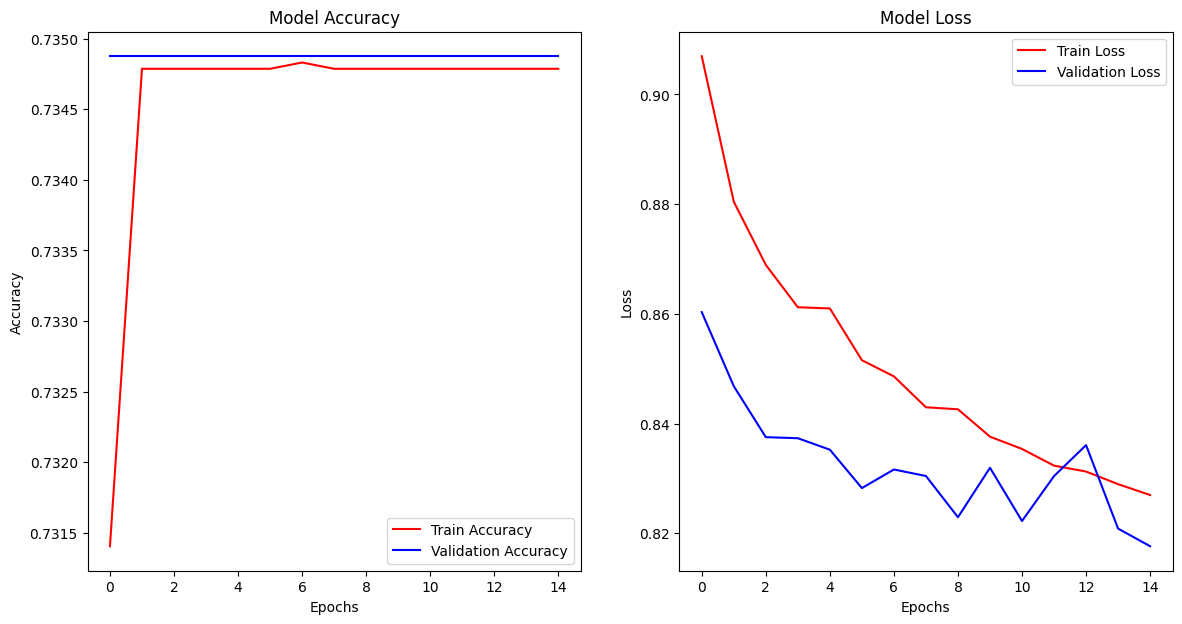

In [10]:
accuracyGraph(history)

1/1 [==============================] - 2s 2s/step
              precision    recall  f1-score   support

           0       0.73      1.00      0.85      5162
           1       0.00      0.00      0.00       489
           2       0.00      0.00      0.00      1058
           3       0.00      0.00      0.00       175
           4       0.00      0.00      0.00       142

    accuracy                           0.73      7026
   macro avg       0.15      0.20      0.17      7026
weighted avg       0.54      0.73      0.62      7026

[[5162    0    0    0    0]
 [ 489    0    0    0    0]
 [1058    0    0    0    0]
 [ 175    0    0    0    0]
 [ 142    0    0    0    0]]


c:\Users\Computing\anaconda3\envs\AML\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Computing\anaconda3\envs\AML\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Computing\anaconda3\envs\AML\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


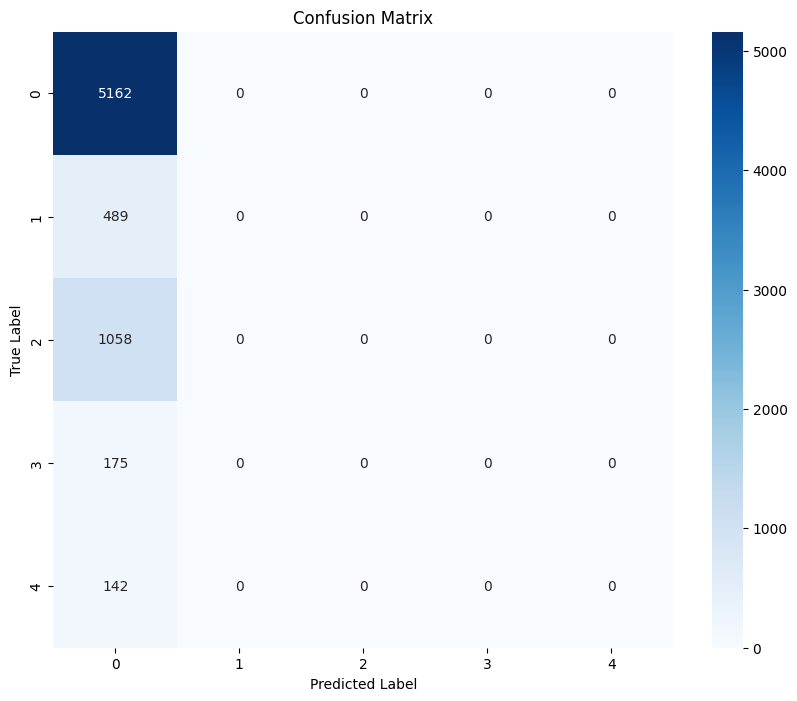

In [11]:
show_confusion_matrix(model)

In [12]:
_metrices = model.evaluate(test_dataset)
# _metrices = model.evaluate(test_generator, steps=test_generator.samples // batch_size)

print("Test Metrices", _metrices)

220/220 [==============================] - 18s 83ms/step - loss: 0.8232 - accuracy: 0.7347 - auc: 0.9098 - balanced_accuracy: 0.2650 - fscore: 0.2252 - kappa_score: 0.0000e+00 - precision: 0.7448 - recall: 0.7183
Test Metrices [0.823203980922699, 0.7346996665000916, 0.9098145365715027, 0.2650000751018524, 0.22515204548835754, 0.0, 0.7448347210884094, 0.7183319330215454]


In [13]:


x = base_model.output
x = GlobalAveragePooling2D()(x)
# x = Dense(1024, activation='relu')(x)
x = tf.keras.layers.Dropout(0.1)(x)
x = tf.keras.layers.Dense(256, activation='relu')(x)
x = tf.keras.layers.Dropout(0.1)(x)
x = tf.keras.layers.Dense(256, activation='relu')(x)
x = tf.keras.layers.Dropout(0.1)(x)
predictions = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Fine-tuning: Unfreeze some layers of the base model
for layer in base_model.layers[:15]:  # Adjust the index as needed
    layer.trainable = False
for layer in base_model.layers[15:]:
    layer.trainable = True


# Recompile the model with a lower learning rate
# model.compile(optimizer=Adam(lr=0.00001), loss=loss_fn, metrics=['accuracy'])
model.compile(optimizer=Adam(lr=learning_rate), loss="categorical_crossentropy", metrics=metrics)

# Continue training (fine-tuning)
# Train the model
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=epochs,
    batch_size=BATCH_SIZE
)

Epoch 1/15


c:\Users\Computing\anaconda3\envs\AML\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


703/703 [==============================] - 130s 156ms/step - loss: 0.8844 - accuracy: 0.7301 - auc: 0.8952 - balanced_accuracy: 0.2647 - fscore: 0.2239 - kappa_score: -1.0253e-04 - precision: 0.7375 - recall: 0.7191 - val_loss: 0.8322 - val_accuracy: 0.7349 - val_auc: 0.9070 - val_balanced_accuracy: 0.2670 - val_fscore: 0.2271 - val_kappa_score: 0.0000e+00 - val_precision: 0.7365 - val_recall: 0.7326
Epoch 2/15
703/703 [==============================] - 131s 157ms/step - loss: 0.8346 - accuracy: 0.7347 - auc: 0.9049 - balanced_accuracy: 0.2689 - fscore: 0.2285 - kappa_score: 0.0028 - precision: 0.7444 - recall: 0.7191 - val_loss: 0.8094 - val_accuracy: 0.7349 - val_auc: 0.9136 - val_balanced_accuracy: 0.2670 - val_fscore: 0.2271 - val_kappa_score: 0.0000e+00 - val_precision: 0.7528 - val_recall: 0.7169
Epoch 3/15
703/703 [==============================] - 132s 158ms/step - loss: 0.8042 - accuracy: 0.7371 - auc: 0.9132 - balanced_accuracy: 0.2798 - fscore: 0.2436 - kappa_score: 0.0369 -

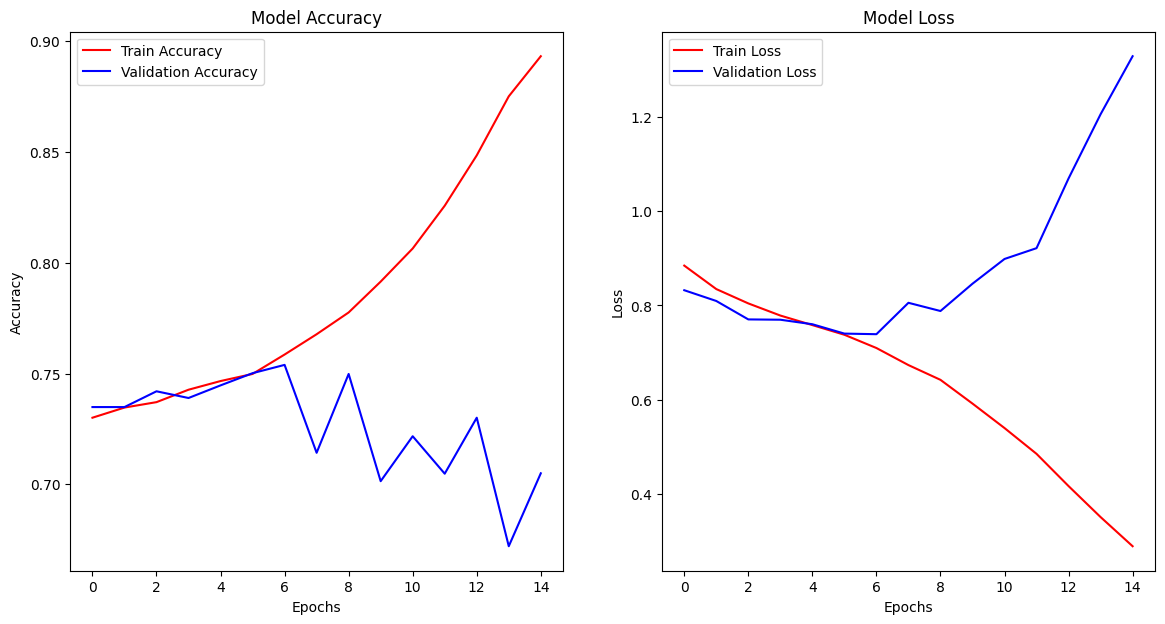

In [14]:
accuracyGraph(history)

1/1 [==============================] - 0s 117ms/step
              precision    recall  f1-score   support

           0       0.78      0.91      0.84      5162
           1       0.13      0.06      0.08       489
           2       0.33      0.17      0.22      1058
           3       0.30      0.17      0.21       175
           4       0.34      0.39      0.36       142

    accuracy                           0.71      7026
   macro avg       0.38      0.34      0.34      7026
weighted avg       0.65      0.71      0.67      7026

[[4700  137  256   18   51]
 [ 412   28   44    0    5]
 [ 757   44  182   38   37]
 [  78    2   50   29   16]
 [  45    2   28   12   55]]


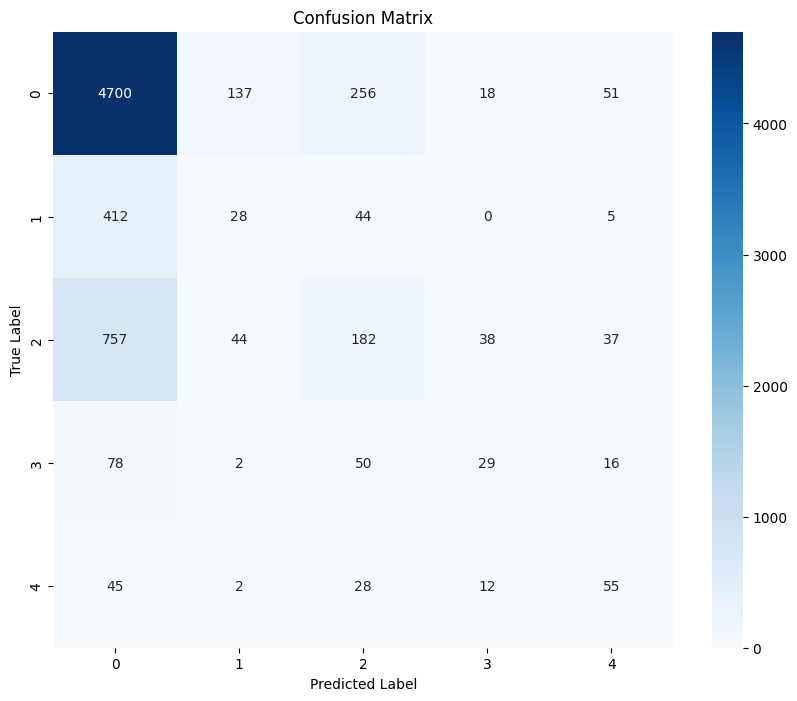

In [15]:
show_confusion_matrix(model)

In [16]:
_metrices = model.evaluate(test_dataset)
# _metrices = model.evaluate(test_generator, steps=test_generator.samples // batch_size)

print("Test Metrices", _metrices)

220/220 [==============================] - 18s 83ms/step - loss: 1.3364 - accuracy: 0.7108 - auc: 0.8871 - balanced_accuracy: 0.3674 - fscore: 0.3181 - kappa_score: 0.1856 - precision: 0.7273 - recall: 0.6943
Test Metrices [1.3364112377166748, 0.7107884883880615, 0.8870847821235657, 0.36740773916244507, 0.3180578052997589, 0.1856461763381958, 0.7272998094558716, 0.6942784190177917]


In [17]:
from tensorflow.keras.utils import plot_model
from IPython.display import Image
plot_model(model, to_file='convnet.png', show_shapes=True,show_layer_names=True)
Image(filename='convnet.png')

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


FileNotFoundError: [Errno 2] No such file or directory: 'convnet.png'